# Network Intrusion Detection System - NIDS

# 1. Prerequisites

## 1.1. Import Libraries

In [1]:
import os
import gc
import optuna
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from prettytable import PrettyTable
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
from sklearn.svm import LinearSVC

2025-11-05 11:39:13.196752: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1.2. Define functions

In [2]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def missing_values(df):
    """
    Print a table with missing values
    """
    table = PrettyTable(["Column", "All Values", "Missing Values", "% of missing values"])
    NaN_columns = []
    columns = df.columns
    for column in columns:
        all_values = df[column].count()
        missing_values = df[column].isna().sum()
        if missing_values > 0:
            NaN_columns.append(column)
        percentage = f'{(missing_values / all_values)*100:.2f}'
        table.add_row([column, all_values, missing_values, f'{percentage}%'])
    data = table.get_string()
    #with open(f"Missing_table.txt", 'w') as f:
    #    f.write(data)
    print(table)
    if len(NaN_columns) > 0:
        print(f"Columns with missing values: {NaN_columns}")
    #print(f"Table saved as Missing_table.txt")

def hist_plot(label, count):
    _dict = {}
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    ax.set_title('Network traffic type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Network traffic type')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    #plt.savefig("Traffic_type_distribution.png")

def attack_plot(label, count):
    _dict = {}
    label = [x for x in label if x != 'BENIGN']
    count = count.iloc[1:len(count)]
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    ax.set_title('Attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Traffic type')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    #plt.savefig("attack_type_distribution.png")

def plotResults(df, columns_list, rows, columns):
    """
    Plot results
    """
    fig, axes = plt.subplots(rows, columns)
    for ax, col in zip(axes.ravel(), columns_list):
        df[col].plot(ax=ax,
                     kind="bar",
                     figsize=(15,50),
                     fontsize=12)
        if col in ["Accuracy", "Precision", "F1", "Recall"]:
            ax.set_title(f"{col} (Higher is better)", fontsize=20)
        else:
            ax.set_title(f"{col} (Lower is better)", fontsize=20)
        ax.tick_params(axis='x', labelrotation=0)

In [3]:
for dirname, _, filenames in os.walk('../datasets/CIC_IDS_2017/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# 2. Data Analysis

In [4]:
monday = pd.read_csv('../../datasets/CIC_IDS_2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
tuesday = pd.read_csv('../../datasets/CIC_IDS_2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
wednesday = pd.read_csv('../../datasets/CIC_IDS_2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_morning = pd.read_csv('../../datasets/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_afternoon = pd.read_csv('../../datasets/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_ddos = pd.read_csv('../../datasets/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_pcap = pd.read_csv('../../datasets/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_morning = pd.read_csv('../../datasets/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv', sep=",", encoding='utf-8')
monday.name = 'Monday'
tuesday.name = 'Tuesday'
wednesday.name = 'Wednesday'
thursday_morning.name = 'Thursday_Morning'
thursday_afternoon.name = 'Thursday_Afternoon'
friday_ddos.name = 'Friday_DDoS'
friday_pcap.name = 'Friday_Pcap'
friday_morning.name = 'Friday_Morning'

In [5]:
dataframes = [monday, tuesday, wednesday, thursday_morning, thursday_afternoon, friday_ddos, friday_morning, friday_pcap]
data = pd.concat(dataframes)

In [6]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 286466
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

In [8]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [9]:
data[' Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [10]:
data[' Label'].value_counts()

 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [11]:
data = data.replace([-np.inf, np.inf], np.nan)
missing_values(data)

+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |  2830743   |       0        |        0.00%        |
|         Flow Duration        |  2830743   |       0        |        0.00%        |
|       Total Fwd Packets      |  2830743   |       0        |        0.00%        |
|    Total Backward Packets    |  2830743   |       0        |        0.00%        |
| Total Length of Fwd Packets  |  2830743   |       0        |        0.00%        |
|  Total Length of Bwd Packets |  2830743   |       0        |        0.00%        |
|     Fwd Packet Length Max    |  2830743   |       0        |        0.00%        |
|     Fwd Packet Length Min    |  2830743   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |  2830743   |       0        |   

In [12]:
data.dropna(inplace=True)
missing_values(data)

+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |  2827876   |       0        |        0.00%        |
|         Flow Duration        |  2827876   |       0        |        0.00%        |
|       Total Fwd Packets      |  2827876   |       0        |        0.00%        |
|    Total Backward Packets    |  2827876   |       0        |        0.00%        |
| Total Length of Fwd Packets  |  2827876   |       0        |        0.00%        |
|  Total Length of Bwd Packets |  2827876   |       0        |        0.00%        |
|     Fwd Packet Length Max    |  2827876   |       0        |        0.00%        |
|     Fwd Packet Length Min    |  2827876   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |  2827876   |       0        |   

In [13]:
label = data[' Label'].value_counts().index.tolist()
count = data[' Label'].value_counts()

In [14]:
label

['BENIGN',
 'DoS Hulk',
 'PortScan',
 'DDoS',
 'DoS GoldenEye',
 'FTP-Patator',
 'SSH-Patator',
 'DoS slowloris',
 'DoS Slowhttptest',
 'Bot',
 'Web Attack � Brute Force',
 'Web Attack � XSS',
 'Infiltration',
 'Web Attack � Sql Injection',
 'Heartbleed']

In [15]:
count

 Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [ ]:
hist_plot(label, count)

In [ ]:
attack_plot(label, count)

# 4. Prepare data

Prepare data for Autoencoder training

In [18]:
data['Class'] = ['Benign' if x == 'BENIGN' else 'Malicious' for x in data[' Label']]

In [16]:
data['Class'].unique()

KeyError: 'Class'

In [18]:
benign_data = data[data[' Label']=='BENIGN']

In [18]:
data[' Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [19]:
X = data.drop([' Label'], axis=1)
y = data[' Label']

In [20]:
X.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0


In [21]:
X.drop([' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk',
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes',
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', ' act_data_pkt_fwd',
       ' min_seg_size_forward', 'Active Mean', ' Active Std', ' Active Max',
       ' Active Min', 'Idle Mean', ' Idle Std', ' Idle Max', ' Idle Min'], axis=1, inplace=True)

In [22]:
X.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [23]:
len(X.columns)

55

In [24]:
y.unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [25]:
len(y.unique())

15

## 4.1 Data Normalization

In [26]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [27]:
X

array([[ 2.25050642, -0.43961241, -0.00982461, ..., -0.55176329,
        -0.28068619, -0.50580489],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.55176329,
        -0.28068619, -0.50580489],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.55176329,
        -0.28068619, -0.50580489],
       ...,
       [-0.41689841, -0.4348067 ,  0.08083571, ...,  3.20529322,
        -0.20341564,  2.95612101],
       [-0.41689841, -0.43536915,  0.05417091, ...,  2.42039836,
        -0.16992918,  2.42932349],
       [-0.41689841, -0.43406035,  0.04883795, ...,  2.38568705,
        -0.15889691,  2.39310164]], shape=(2827876, 55))

## 4.2 Encode data

In [35]:
"""
onehotencoder = OneHotEncoder()
y = y.values.reshape(-1, 1)
y = onehotencoder.fit_transform(y).toarray()
y = y[:, 0]
"""

'\nonehotencoder = OneHotEncoder()\ny = y.values.reshape(-1, 1)\ny = onehotencoder.fit_transform(y).toarray()\ny = y[:, 0]\n'

In [28]:
le = LabelEncoder()

y = le.fit_transform(y)

In [29]:
y

array([0, 0, 0, ..., 0, 0, 0], shape=(2827876,))

In [30]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [31]:
labels = pd.DataFrame({'Labels': y})
encoded_labels = labels['Labels'].unique()
for label in sorted(encoded_labels):
    print(f'{label}: {le.inverse_transform([label])[0]}')

0: BENIGN
1: Bot
2: DDoS
3: DoS GoldenEye
4: DoS Hulk
5: DoS Slowhttptest
6: DoS slowloris
7: FTP-Patator
8: Heartbleed
9: Infiltration
10: PortScan
11: SSH-Patator
12: Web Attack � Brute Force
13: Web Attack � Sql Injection
14: Web Attack � XSS


## 4.3 Principal component analysis

In [26]:
%%time
num_components = 10
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X)
feature_selector = SelectKBest(score_func=f_classif, k='all')
X = feature_selector.fit_transform(X_pca, y)
X = X.reshape(X.shape[0], num_components, 1)

CPU times: user 5.24 s, sys: 212 ms, total: 5.45 s
Wall time: 1.36 s


## 4.4 Save data

In [27]:
np.save('../datasets/CIC_IDS_2017/prepared_train_data.npy', X)
np.save('../datasets/CIC_IDS_2017/prepared_train_labels.npy', y)

## 4.5 Load data

In [28]:
X = np.load('../datasets/CIC_IDS_2017/prepared_train_data.npy')
y = np.load('../datasets/CIC_IDS_2017/prepared_train_labels.npy')

In [33]:
X

array([[ 2.01499235, -0.37266405, -0.01034975, ..., -0.58525619,
        -0.2958152 , -0.56731398],
       [ 2.01499235, -0.37266415, -0.01034975, ..., -0.58525619,
        -0.2958152 , -0.56731398],
       [ 2.01499235, -0.37266415, -0.01034975, ..., -0.58525619,
        -0.2958152 , -0.56731398],
       ...,
       [-0.45392084, -0.36729471,  0.07090613, ...,  5.75224099,
        -0.22540898,  6.82247884],
       [-0.45392084, -0.36792312,  0.04700734, ...,  4.42826066,
        -0.19489729,  5.69798206],
       [-0.45392084, -0.36646081,  0.04222758, ...,  4.36970875,
        -0.18484508,  5.62066325]], shape=(2271320, 55))

In [34]:
y

array([0, 0, 0, ..., 0, 0, 0], shape=(2271320,))

# Isolation Forest

In [54]:
from sklearn.ensemble import IsolationForest

In [91]:
%%time

clf = IsolationForest(n_estimators=200, max_samples=150, contamination='auto', max_features=1.0, random_state=42)
clf.fit(X_train)

CPU times: user 2.81 s, sys: 36.7 ms, total: 2.85 s
Wall time: 2.87 s


,n_estimators,200
,max_samples,150
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [92]:
%%time
    
y_pred = clf.predict(X_test)
np.unique(y_pred)

CPU times: user 3.01 s, sys: 11.9 ms, total: 3.03 s
Wall time: 3.04 s


array([-1,  1])

In [93]:
y_pred = np.where(y_pred == -1, 1, 0)
np.unique(y_pred)

array([0, 1])

In [94]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [95]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["Isolation Forest"] = results

pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
Isolation Forest,0.812187,0.792361,0.798391,0.812187,0.187813,0.187813,0.433374


In [96]:
with open('../../models/CIC_IDS_2017/isolation_forest.pkl', 'wb') as f:
    pickle.dump(clf, f)

# Autoencoder

Training autoencoder for anomaly detection

In [32]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses

"""
# Configure GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPU(s), {len(logical_gpus)} Logical GPU(s)")
    except RuntimeError as e:
        # Memory growth must be set before GPUs are initialized
        print(e)
"""

'\n# Configure GPU memory growth\ngpus = tf.config.list_physical_devices(\'GPU\')\nif gpus:\n    try:\n        # Enable memory growth for all GPUs\n        for gpu in gpus:\n            tf.config.experimental.set_memory_growth(gpu, True)\n\n        logical_gpus = tf.config.list_logical_devices(\'GPU\')\n        print(f"{len(gpus)} Physical GPU(s), {len(logical_gpus)} Logical GPU(s)")\n    except RuntimeError as e:\n        # Memory growth must be set before GPUs are initialized\n        print(e)\n'

In [33]:
class SimpleAutoencoder(Model):
    def __init__(self, latent_dimensions):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(X.shape[1],)),
            #layers.Flatten(),
            layers.Dense(latent_dimensions, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(X.shape[1], activation='sigmoid'),
            layers.Reshape((X.shape[1],))
        ])
    
    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded

In [34]:
print(tf.sysconfig.get_build_info())

OrderedDict({'cpu_compiler': 'clang 18', 'cuda_compute_capabilities': ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90'], 'cuda_version': '12.5.1', 'cudnn_version': '9', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': False})


In [37]:
latent_dimensions = 10
autoencoder = SimpleAutoencoder(latent_dimensions)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(X_train, X_train,
                epochs=1,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

2025-11-05 11:41:37.209135: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 528812680 exceeds 10% of free system memory.
2025-11-05 11:41:38.311074: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 528812680 exceeds 10% of free system memory.


9390/9390 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.6802 - val_loss: 0.7075


In [43]:
autoencoder_path = "../../models/CIC_IDS_2017/autoencoder.keras"
autoencoder.save(autoencoder_path)

In [44]:
!ls ../../models/CIC_IDS_2017/

autoencoder.keras     README		      xgb_clf.pkl
isolation_forest.pkl  xgb_clf_multiclass.pkl


# 5. Create a model

Testing these models:
1. K Nearest Neighbour
2. Random Forest
3. Gradient Boost:
    * XGBoost;
    * CatBoost;
    * LightGBM.
4. Support Vector Machine;
5. Neural Network.

In [41]:
results_dict = {}

In [36]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

CPU times: user 1.84 s, sys: 86.9 ms, total: 1.93 s
Wall time: 1.95 s


((2403694, 55), (2403694,), (424182, 55), (424182,))

## 5.1. K Nearest Neighbour

In [ ]:
%%time

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["KNN"] = results

In [ ]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

In [72]:
with open('knn_clf.pkl', 'wb') as f:
    pickle.dump(knn_clf, f)

## 5.2. Random Forest

In [38]:
%%time

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

CPU times: user 36min 30s, sys: 8.05 s, total: 36min 38s
Wall time: 5min 16s


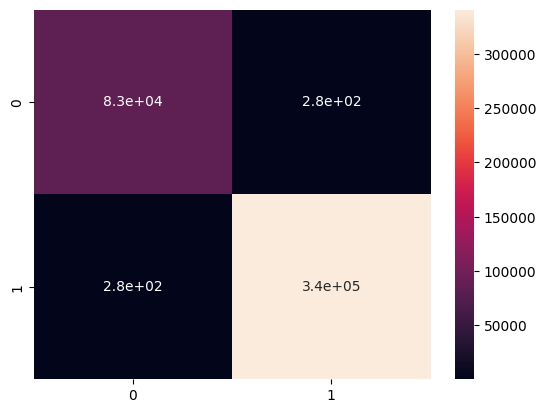

In [39]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [40]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [41]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["RF"] = results

In [42]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996900,0.996908,0.996903,0.996900,0.003100,0.003100,0.055678
RF,0.998677,0.998677,0.998677,0.998677,0.001323,0.001323,0.036367


In [71]:
with open('rf_clf.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

## 5.3. XGBoost

In [35]:
%%time

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

CPU times: user 22min 50s, sys: 2.86 s, total: 22min 52s
Wall time: 2min 59s


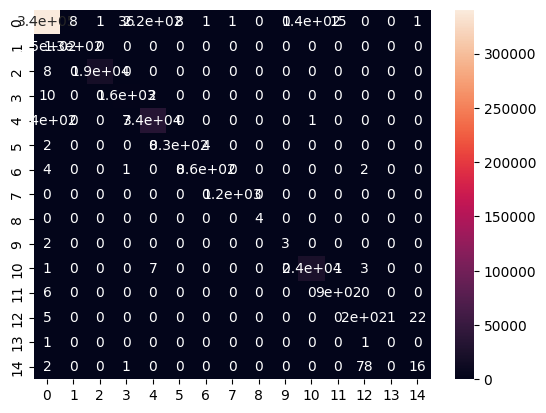

In [36]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [37]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [38]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["XGBoost"] = results

In [39]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
XGBoost,0.997904,0.997846,0.997801,0.997904,0.009126,0.060585,0.24614


In [40]:
!ls ../../models/CIC_IDS_2017

README	xgb_clf.pkl


In [41]:
with open('../../models/CIC_IDS_2017/xgb_clf_multiclass.pkl', 'wb') as f:
    pickle.dump(xgb_clf, f)

## 5.4. LightGBM

In [51]:
%%time

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

[LightGBM] [Info] Number of positive: 1930312, number of negative: 473382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2403694, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803061 -> initscore=1.405534
[LightGBM] [Info] Start training from score 1.405534


/home/kostas/Documents/Programs/Python/RT_IDS/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CPU times: user 32.6 s, sys: 55.4 ms, total: 32.7 s
Wall time: 8.36 s


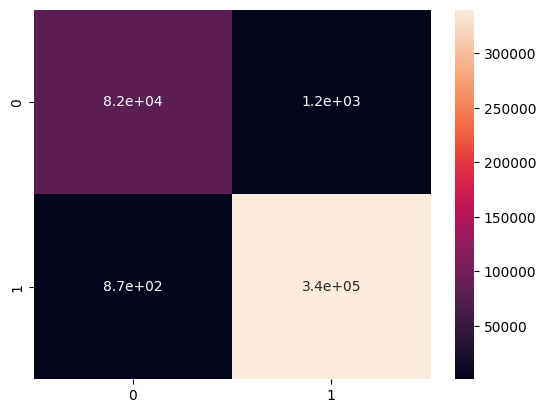

In [52]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [53]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [54]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["LightGBM"] = results

In [55]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996900,0.996908,0.996903,0.996900,0.003100,0.003100,0.055678
RF,0.998677,0.998677,0.998677,0.998677,0.001323,0.001323,0.036367
XGBoost,0.996886,0.996885,0.996886,0.996886,0.003114,0.003114,0.055805
LightGBM,0.995089,0.995084,0.995086,0.995089,0.004911,0.004911,0.070076


In [70]:
with open('lgbm_clf.pkl', 'wb') as f:
    pickle.dump(lgbm_clf, f)

## 5.5. Linear Support Vector Classifier

In [56]:
%%time

svc_clf = LinearSVC()
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)

CPU times: user 4.56 s, sys: 60.3 ms, total: 4.62 s
Wall time: 4.66 s


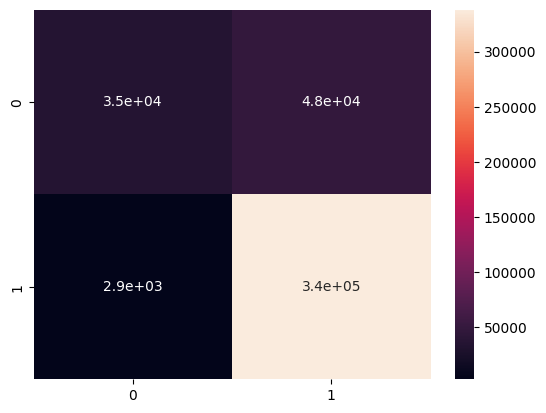

In [57]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [58]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [59]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["LSVC"] = results

In [60]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"]).T

,KNN,RF,XGBoost,LightGBM,LSVC
Accuracy,0.996900,0.998677,0.996886,0.995089,0.879521
Precision,0.996908,0.998677,0.996885,0.995084,0.884579
F1,0.996903,0.998677,0.996886,0.995086,0.860765
Recall,0.996900,0.998677,0.996886,0.995089,0.879521
MAE,0.003100,0.001323,0.003114,0.004911,0.120479
MSE,0.003100,0.001323,0.003114,0.004911,0.120479
RMSE,0.055678,0.036367,0.055805,0.070076,0.347101


In [73]:
with open('svc_clf.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

## 5.6. Neural Network

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1971029, 10, 1),
 (1971029,),
 (432665, 10, 1),
 (432665,),
 (424182, 10, 1),
 (424182,))

In [62]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/Programs/Python/RT_IDS/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1759995452.684515   28596 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1759995452.796997   28596 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [63]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,232 (270.44 KB)

 Trainable params: 69,232 (270.44 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
%%time
model.fit(X_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

Epoch 1/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - accuracy: 0.9681 - loss: 0.0739 - val_accuracy: 0.9762 - val_loss: 0.0579
Epoch 2/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 124s 2ms/step - accuracy: 0.9747 - loss: 0.0574 - val_accuracy: 0.9754 - val_loss: 0.0568
Epoch 3/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 123s 2ms/step - accuracy: 0.9763 - loss: 0.0542 - val_accuracy: 0.9805 - val_loss: 0.0502
Epoch 4/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 119s 2ms/step - accuracy: 0.9774 - loss: 0.0517 - val_accuracy: 0.9785 - val_loss: 0.0492
Epoch 5/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 119s 2ms/step - accuracy: 0.9785 - loss: 0.0492 - val_accuracy: 0.9778 - val_loss: 0.0522
Epoch 6/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 120s 2ms/step - accuracy: 0.9804 - loss: 0.0461 - val_accuracy: 0.9807 - val_loss: 0.0425
Epoch 7/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 120s 2ms/step - accuracy: 0.9824 - loss: 0.0434 - val_accuracy: 0.9830 - val_loss: 0.0416
Epoch 8/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 119s 2ms/step - ac

In [65]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 9s 704us/step


In [66]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.9823 - loss: 0.0448


In [77]:
model.save('ANN.keras')

In [67]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["RNN"] = results

In [68]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

# 6. Plotting data

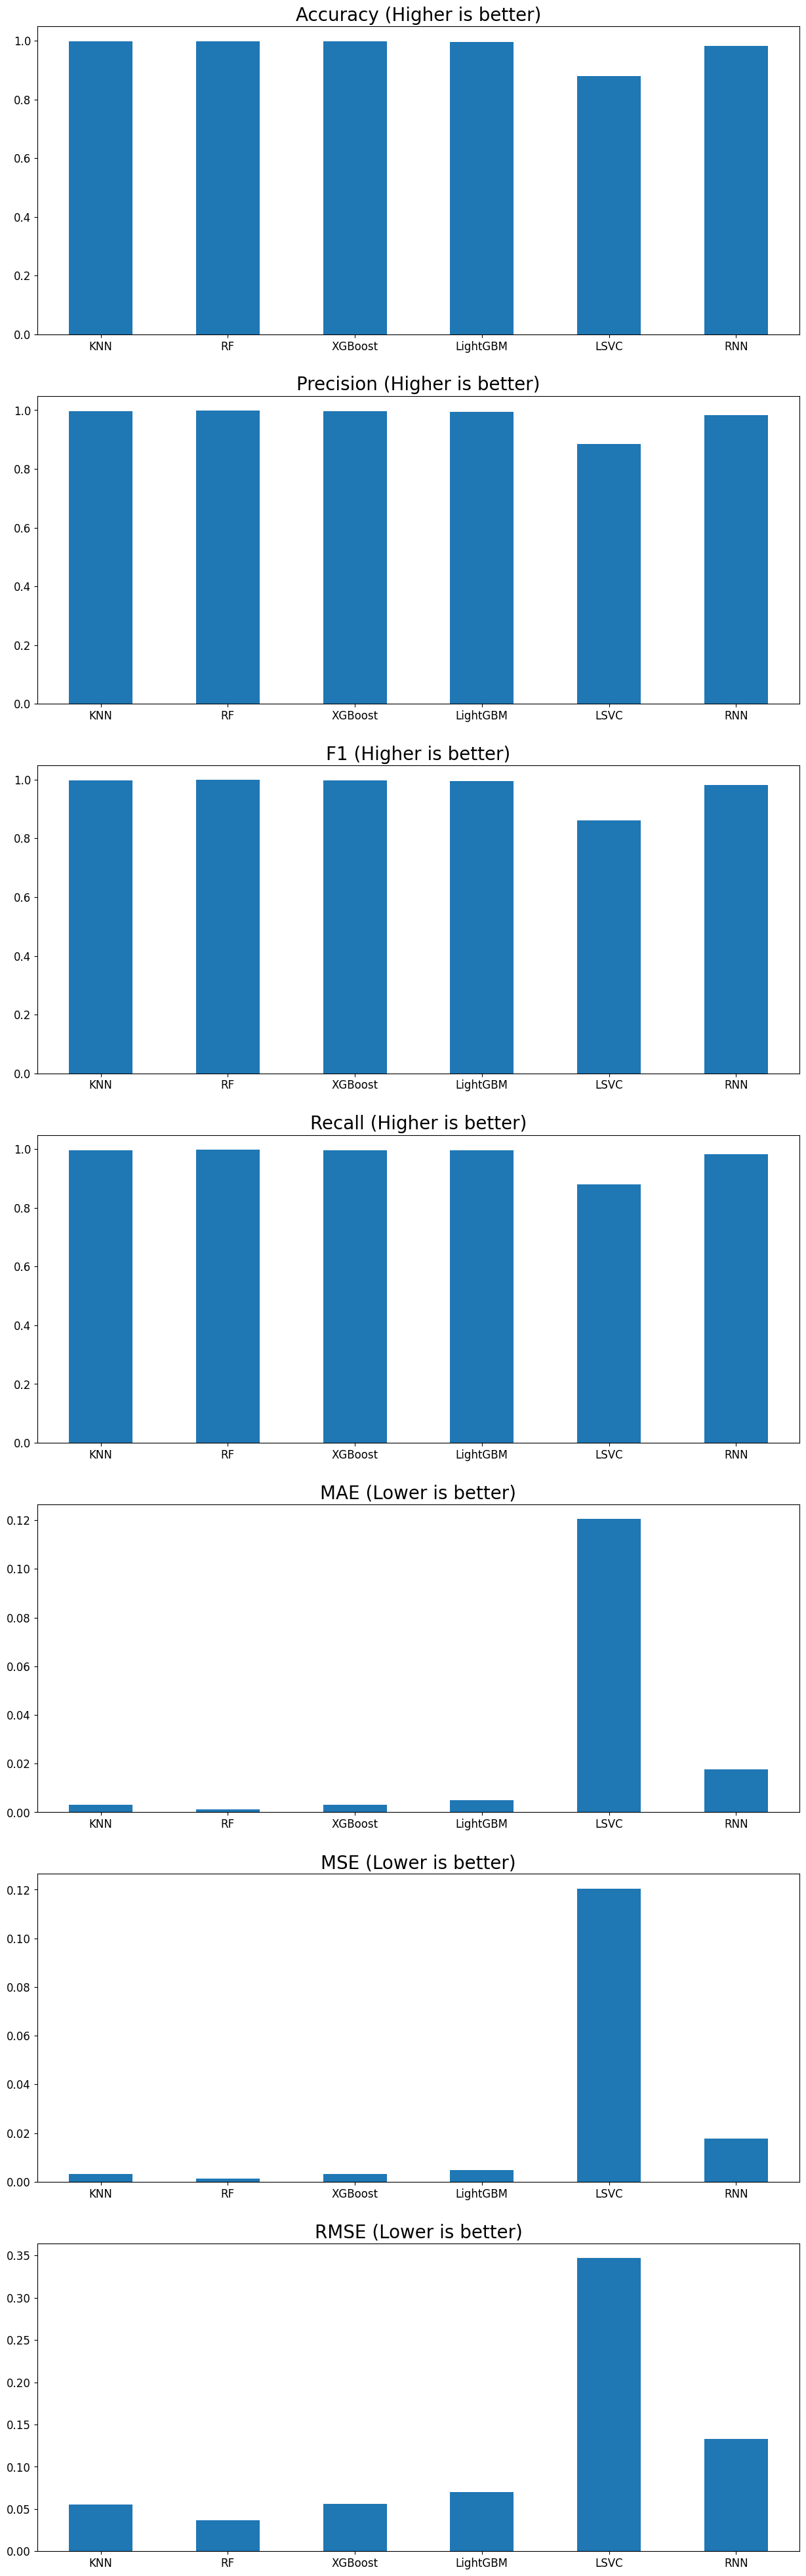

In [69]:
plotResults(results_df, results_df.columns, len(results_df.columns), 1)